In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

Exercise 9.

In [2]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train_full = x_train_full / 255
x_test = x_test / 255

x_train, x_valid = x_train_full[5000:], x_train_full[:5000]
y_train, y_valid = y_train_full[5000:], y_train_full[:5000]

In [3]:
x_train.shape

(45000, 32, 32, 3)

In [4]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    
    
def show_reconstructions(model, images=x_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [5]:
denoising_encoder = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape=[32, 32, 3]),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),    
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
])

denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(16 * 16 * 32, activation='selu', 
                       input_shape=[512]),
    keras.layers.Reshape([16, 16, 32]),
    keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2, 
                                 padding='same', activation='sigmoid')
])

denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss='binary_crossentropy',
                     optimizer='Nadam', 
                     metrics=[rounded_accuracy])

In [6]:
denoising_encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0

In [7]:
denoising_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              4202496   
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 3)         867       
Total params: 4,203,363
Trainable params: 4,203,363
Non-trainable params: 0
_________________________________________________________________


In [8]:
denoising_ae.fit(x_train, x_train, epochs=20, 
                 validation_data=(x_valid, x_valid))

Epoch 1/20
1407/1407 [==============================] - 58s 39ms/step - loss: 0.5884 - rounded_accuracy: 0.8450 - val_loss: 0.5770 - val_rounded_accuracy: 0.8697
Epoch 2/20
1407/1407 [==============================] - 56s 40ms/step - loss: 0.5752 - rounded_accuracy: 0.8759 - val_loss: 0.5692 - val_rounded_accuracy: 0.8955
Epoch 3/20
1407/1407 [==============================] - 56s 40ms/step - loss: 0.5707 - rounded_accuracy: 0.8879 - val_loss: 0.5666 - val_rounded_accuracy: 0.9016
Epoch 4/20
1407/1407 [==============================] - 57s 40ms/step - loss: 0.5682 - rounded_accuracy: 0.8948 - val_loss: 0.5755 - val_rounded_accuracy: 0.8907
Epoch 5/20
1407/1407 [==============================] - 54s 38ms/step - loss: 0.5666 - rounded_accuracy: 0.8997 - val_loss: 0.5613 - val_rounded_accuracy: 0.9112
Epoch 6/20
1407/1407 [==============================] - 53s 37ms/step - loss: 0.5652 - rounded_accuracy: 0.9037 - val_loss: 0.5606 - val_rounded_accuracy: 0.9134
Epoch 7/20
1407/1407 [======

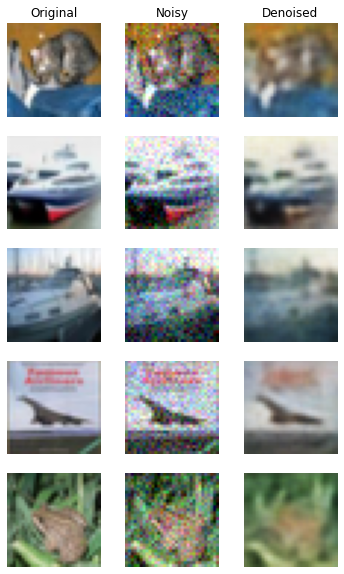

In [9]:
n_images = 5
new_images = x_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * 0.1
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(np.clip(new_images_noisy[index], 0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")
plt.show()

In [10]:
from tensorflow.keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train)
y_valid_one_hot = to_categorical(y_valid)
y_test_one_hot = to_categorical(y_test)

x_train_small, y_train_small = x_train[:500], y_train_one_hot[:500]

In [11]:
y_train_small[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(x_train_small, y_train_small, batch_size=20)
test_generator = test_datagen.flow(x_test, y_test_one_hot, batch_size=20)

In [13]:
cls = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape=[32, 32, 3]),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),    
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
])

In [14]:
weights = denoising_encoder.get_weights()
cls.set_weights(weights)

In [15]:
cls.pop()

for layer in cls.layers:
    layer.trainable = False

cls.add(keras.layers.Dense(512, activation='relu'))
cls.add(keras.layers.Dense(10, activation='softmax'))
cls.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_1 (GaussianNo (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 32)       

In [16]:
cls.compile(loss='categorical_crossentropy', 
            optimizer=keras.optimizers.Nadam(), 
            metrics=['acc'])

cls.fit(train_generator, epochs=15)

Epoch 1/15
25/25 [==============================] - 1s 13ms/step - loss: 2.1698 - acc: 0.2180
Epoch 2/15
25/25 [==============================] - 0s 12ms/step - loss: 2.0420 - acc: 0.2780
Epoch 3/15
25/25 [==============================] - 0s 12ms/step - loss: 1.9549 - acc: 0.3200
Epoch 4/15
25/25 [==============================] - 0s 13ms/step - loss: 1.8770 - acc: 0.3440
Epoch 5/15
25/25 [==============================] - 0s 12ms/step - loss: 1.8384 - acc: 0.3480
Epoch 6/15
25/25 [==============================] - 0s 12ms/step - loss: 1.8046 - acc: 0.3520
Epoch 7/15
25/25 [==============================] - 0s 13ms/step - loss: 1.7885 - acc: 0.3400
Epoch 8/15
25/25 [==============================] - 0s 12ms/step - loss: 1.7464 - acc: 0.3760
Epoch 9/15
25/25 [==============================] - 0s 13ms/step - loss: 1.7209 - acc: 0.4180
Epoch 10/15
25/25 [==============================] - 0s 13ms/step - loss: 1.6709 - acc: 0.4160
Epoch 11/15
25/25 [==============================] - 0s 13m

In [17]:
for i in range(23):
    if (i > 13):
        cls.layers[i].trainable = True

In [18]:
cls.compile(loss='categorical_crossentropy', 
            optimizer='Nadam', 
            metrics=['acc'])

cls.fit(train_generator, epochs=15)

Epoch 1/15
25/25 [==============================] - 1s 20ms/step - loss: 1.6314 - acc: 0.4320
Epoch 2/15
25/25 [==============================] - 1s 22ms/step - loss: 1.6087 - acc: 0.4380
Epoch 3/15
25/25 [==============================] - 1s 22ms/step - loss: 1.5255 - acc: 0.4660
Epoch 4/15
25/25 [==============================] - 1s 21ms/step - loss: 1.5802 - acc: 0.4440
Epoch 5/15
25/25 [==============================] - 1s 21ms/step - loss: 1.3860 - acc: 0.5020
Epoch 6/15
25/25 [==============================] - 1s 22ms/step - loss: 1.4047 - acc: 0.4960
Epoch 7/15
25/25 [==============================] - 1s 21ms/step - loss: 1.4641 - acc: 0.4640
Epoch 8/15
25/25 [==============================] - 1s 20ms/step - loss: 1.4156 - acc: 0.5120
Epoch 9/15
25/25 [==============================] - 1s 23ms/step - loss: 1.3424 - acc: 0.5360
Epoch 10/15
25/25 [==============================] - 1s 23ms/step - loss: 1.3108 - acc: 0.5600
Epoch 11/15
25/25 [==============================] - 1s 20m

In [19]:
cls.evaluate(test_generator)

500/500 [==============================] - 2s 5ms/step - loss: 1.8302 - acc: 0.3940


[1.8301589488983154, 0.39399999380111694]

In [20]:
cls_2 = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape=[32, 32, 3]),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),    
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(10, activation='softmax'),
])
cls_2.compile(loss='categorical_crossentropy', 
            optimizer='Nadam', 
            metrics=['acc'])

cls_2.fit(train_generator, epochs=30)

Epoch 1/30
25/25 [==============================] - 3s 33ms/step - loss: 3.4995 - acc: 0.1480
Epoch 2/30
25/25 [==============================] - 1s 33ms/step - loss: 2.8103 - acc: 0.1680
Epoch 3/30
25/25 [==============================] - 1s 31ms/step - loss: 2.1680 - acc: 0.2200
Epoch 4/30
25/25 [==============================] - 1s 34ms/step - loss: 2.1679 - acc: 0.2040
Epoch 5/30
25/25 [==============================] - 1s 32ms/step - loss: 2.0772 - acc: 0.2200
Epoch 6/30
25/25 [==============================] - 1s 32ms/step - loss: 2.0428 - acc: 0.2560
Epoch 7/30
25/25 [==============================] - 1s 30ms/step - loss: 2.0434 - acc: 0.2480
Epoch 8/30
25/25 [==============================] - 1s 34ms/step - loss: 2.0013 - acc: 0.2720
Epoch 9/30
25/25 [==============================] - 1s 32ms/step - loss: 1.9477 - acc: 0.2820
Epoch 10/30
25/25 [==============================] - 1s 32ms/step - loss: 1.9704 - acc: 0.2880
Epoch 11/30
25/25 [==============================] - 1s 31m

In [21]:
cls_2.evaluate(test_generator)

500/500 [==============================] - 2s 5ms/step - loss: 2.4302 - acc: 0.2941


[2.4302408695220947, 0.29409998655319214]